# Advanced Lane Detection

# 1. Importing essential libraries

In [3]:
import numpy as np
import cv2
from mss import mss
from PIL import Image
import matplotlib.pyplot as plt
import os

# 2. Function to seperate the white and the yellow lines from the perspective transformed image using image thresholding.
#### the image passed here is transformed already.
#### lower values for rgb image of yellow color is [0, 38, 55] and higher is [35, 204, 255]
#### same for the white color is [120,120,120] and [255,255,255]
Note: The above values may change for images with very less pixles difference between the white and yellow colors and these values can be optimized more.

#### After image thresholding we use cv2.bitwise_or() and cv2.bitwise_and() to get the complete image with the yellow and white lines and at last convert the image to gray.    

In [4]:
def separate_white_and_yellow_bitwise_pres_gray(image,im_rgb,image_ori):
    #print("adsasd1")
    low_threshold_ylo = np.array([0, 38, 55], dtype=np.uint8)
    high_threshold_ylo = np.array([35, 204, 255], dtype=np.uint8) 
    
    yellow_mask=cv2.inRange(image,low_threshold_ylo,high_threshold_ylo)
    
    low_threshold_ylo1 = np.array([144, 88, 20], dtype=np.uint8)
    high_threshold_ylo1 = np.array([238, 189, 129], dtype=np.uint8) 
    
    yellow_mask1=cv2.inRange(im_rgb,low_threshold_ylo1,high_threshold_ylo1)
    
    #cv2.imshow("21",yellow_mask1)
    low_val=120
    low_threshold_wht1 = np.array([low_val,low_val,low_val], dtype=np.uint8)
    high_threshold_wht1 = np.array([255,255,255], dtype=np.uint8)
    white_mask1=cv2.inRange(im_rgb,low_threshold_wht1,high_threshold_wht1)
    #cv2.imshow("yell",yellow_mask)
    #cv2.imshow("wht1",white_mask1)
    im_or=cv2.bitwise_or(yellow_mask1,white_mask1)
    #cv2.imshow("2s",im_or)
    im_and=cv2.bitwise_and(image_ori,image_ori,mask=im_or)
    #cv2.imshow("a",im_and)
    gray=cv2.cvtColor(im_and,cv2.COLOR_RGB2GRAY)
    #cv2.imshow("ad",gray)
    #to display the converted image
    #plt.title("separate_white_and_yellow_bitwise_pres_gray")
    #plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))
    return gray


# 3. Function to divide the image
#### This function divides the gray(perspective_transformed) image into left and right parts depending on the width_to_break break parameter such that the each left and right lane line falls in the left side and right side image.


In [5]:
def drbx(image,width_to_break,max_width):
    height,width=image.shape[0],image.shape[1]
    imml=image[0:height,0:width_to_break]
    immr=image[0:height,width_to_break:width-max_width]
    #cv2.imshow("left_divided_img",imml)
    #cv2.imshow("right_divided_img",immr)
    val=80
    return imml,immr

# 4. Function to get the sliding windows on the left image from the drbx() function.
#### The height of the sliding window is 50 and width is 100 and the factor for iterating through the image is val. And these values can be changed accordingly to detect the lanes with the different widths

#### This function starts looking for the parts in the image where the pixel value is greater than some threshold value and if it does than it creates a window at that location and the position or location of the winodw is optimized by the location of minimum left and maximum right values of any pixel which is in that sliding box and having value greater than the threshold. And the very first time a window is detected than no more sliding windows will be detected on that particular height. As in left image the search starts from the right side of the image and in the right image the search starts left side so that only lane(left and right) part gets detected.

#### The function returns a image with the sliding boxes on it and the boxes points. 

In [6]:
def get_slided_images_on_prespective199011_left(sobel_img,val,leftorright):
    #  _____
    # |____|---- is to be slided
    # x1,x2   y1,y2
    #intially the starting box x1=0 and x2=150   and y1=height and y2=height-100
    #or x1=0,x2=x1+150 y1=height and y2=y1-100
    #during a iteration the x values specifically the x1 value will be changed, after drawing a particular box then
    #x1=x2(after drawing each box) ==> now x1 is x1+100 and x2 will be x1+100 or (x1+100+100)  or we can do is
    #x1=c and x2=x1+100 and each step when a box is considered then c will be incremented and during starting c=0
    #and similarly for drawing next boxex we wil have x1=c++ and x2=x1+100 and so on till we have x2>=width
    #about y coordinate
    #so after each level of complete checking for boxex over images we will make y1=y2 i.e in second iteration the 
    #y1 will be (height-100) and y2=(height-100)-100 
    #coord=[(x1,y1),(x1,y2),(x2,y2),(x2,y1)]
    
    """" 
    In each level of search at a particular height only one box is detected which contains the lane and the position of that
    box is optimized using the minval and maxval"""
    
    left_mins,right_maxs=[],[]
    
    
    points=[]
    height,width=sobel_img.shape[0],sobel_img.shape[1]
    y1=height
    sobel_cop=sobel_img.copy()
    sobel_cop11=sobel_img.copy()
    ch=0
    boxes=[]
    lanes_points=[]
    #print(sobel_img.shape)
    while True:
        most=[]
        ch=0
        y2=y1-50
        if y2<0:
            break
        c=0
        while True:
            x1=width-c
            x2=x1-100
            if x2<0:
                break
            box=[(x1,y1),(x1,y2),(x2,y2),(x2,y1)]
            if 1 in sobel_cop[y2:y1,x2:x1]:
                ch=ch+1
                minval,maxval=1000000,-1000000
                newx1,newx2=x1,x2
                minval,maxval=1000000,-1000000
                for he in range(0,sobel_cop[y2:y1,x2:x1].shape[0]):
                    for le in range(0,sobel_cop[y2:y1,x2:x1].shape[1]):
                        lis=sobel_cop[y2:y1,x2:x1][he,le]
                        if lis>0.0:
                            #print(sobel_cop[y2:y1,x1:x2][he,le])
                            minval=min(minval,le)
                            maxval=max(maxval,le)
                            points.append((le,he))
                #appending mins in the format of height,(min/max)width
                cha=0
                cha_in=False
                mid=int((-newx2+newx1)/2)
                if minval>mid:
                    cha=minval-mid
                    cha_in=True
                else:
                    cha=mid-minval

                if cha_in:
                    newx1=newx1+cha
                    newx2=newx2+cha
                else:
                    newx1=newx1-cha
                    newx2=newx2-cha
                most.append([(newx1,y1),(newx2,y2),(x2+minval,x2+maxval,y1-((y1-y2)/2))])
                if(len(most)==1):
                    break
            #cv2.imshow("adsd",sobel_img)    
            c=c+val
            
        y1=y2
        try:
            mn=most[0]
            x11,y11,x21,y21,minval,maxval,ht=mn[0][0],mn[0][1],mn[1][0],mn[1][1],mn[2][0],mn[2][1],mn[2][2]
            boxes.append((x11,y11,x21,y21,minval,maxval,ht))
            x11,y11,x21,y21=mn[0][0],mn[0][1],mn[1][0],mn[1][1]
            cv2.rectangle(sobel_cop11,(x11,y11),(x21,y21),(255,255,255),1)
            
        except:
            continue
    return sobel_cop11,boxes

# Similarly function to get the sliding windows on the right image form drbx()

In [7]:
def get_slided_images_on_prespective199011_right(sobel_img,val,leftorright,width_to_break):
    """" 
    In each level of search at a particular height only one box is detected which contains the lane and the position of that
    box is optimized using the minval and maxval"""
    left_mins,right_maxs=[],[]
    
    height,width=sobel_img.shape[0],sobel_img.shape[1]
    y1=height
    sobel_cop=sobel_img.copy()
    sobel_cop1=sobel_img.copy()
    ch=0
    boxes=[]
    lane_points=[]
    while True:
        most=[]
        ch=0
        y2=y1-50
        if y2<0:
            break
        c=0
        while True:
            x1=c
            x2=x1+100
            if x2>width:
                break
            box=[(x1,y1),(x1,y2),(x2,y2),(x2,y1)]
            if 1 in sobel_cop[y2:y1,x1:x2]:
                ch=ch+1
                minval,maxval=1000000,-1000000
                newx1,newx2=x1,x2
                minval,maxval=1000000,-1000000
                for he in range(0,sobel_cop[y2:y1,x1:x2].shape[0]):
                    for le in range(0,sobel_cop[y2:y1,x1:x2].shape[1]):
                        lis=sobel_cop[y2:y1,x1:x2][he,le]
                        if lis>0.0:
                            #print(sobel_cop[y2:y1,x1:x2][he,le])
                            minval=min(minval,le)
                            maxval=max(maxval,le)
                            #lane_points.append((le+600,he))
                cha=0
                cha_in=False
                mid=int((newx2-newx1)/2)
                if minval>mid:
                    cha=minval-mid
                    cha_in=True
                else:
                    cha=mid-minval

                if cha_in:
                    newx1=newx1+cha
                    newx2=newx2+cha
                else:
                    newx1=newx1-cha
                    newx2=newx2-cha
                most.append([(newx1,y1),(newx2,y2),(x1+minval,x1+maxval,y1-((y1-y2)/2))])
                if(len(most)==1):
                    break
            c=c+val
            
        y1=y2
        try:
            mn=most[0]
            x11,y11,x21,y21,minval,maxval,ht=mn[0][0],mn[0][1],mn[1][0],mn[1][1],mn[2][0],mn[2][1],mn[2][2]
            boxes.append((x11+width_to_break,y11,x21+width_to_break,y21,minval+width_to_break,maxval+width_to_break,ht))
            x11,y11,x21,y21=mn[0][0],mn[0][1],mn[1][0],mn[1][1]
            cv2.rectangle(sobel_cop1,(x11,y11),(x21,y21),(255,255,255),1)
        except:
            continue
    return sobel_cop1,boxes

# 5. Function to draw the sliding windows on the warped image
#### This function also handles cases where there are no perfect lines to detect.
#### The function checks if the difference between the no of sliding windows in the left and right part if it is greater than some value and if it does than the function will plot the points using the straight line equation which will be obtained using the max and min points of that side of the lane. The new point will approximately lie on the lane as the orignal points were and the the only difference will be in the heights. The straight line equation will only be formed when the lane is not continous or it has breaks.
#### If the  difference between the no of sliding windows in the left and right part is small then it will directly draw the orignal points over the image
#### The helper_right and helper_left functions will plot the lanes when the straight line equation cannot be formed.
#### The function returns the warped image with the detected lanes over it.

In [8]:
mlp,conslp,mrp,consrp=[],[],[],[]
def helper_right(right_points,left_points):
    a=len(right_points)-len(left_points)
    extra_rights=[]
    for minval,maxval,ht in left_points:
        flag=True
        diff_fac=1000000
        minx,maxx,rht=0,0,0
        for minval2,maxval2,ht2 in right_points:
            if ht==ht2:
                extra_rights.append((minval2,maxval2,ht2))
                flag=False
                break
            else:
                diff=abs(ht-ht2)
                if diff<diff_fac:
                    diff_fac=diff
                    minx=minval2
                    maxx=maxval2
                    rht=ht2
        #now we have the minx and maxx and height as ht values 
        #now we have to plot outthr point at the height ht inside if
        if(flag==True):
            if ht<rht:
                #if this is true then the new points will be below this rht at ht 
                #where the new points will be calculated on the basis of the xmin,xmax,ht
                devi=rht-ht
                ctr_f=0
                if devi>300:
                    ctr_f=3
                elif devi<=300:
                    ctr_f=1
                newxmin=minx-ctr_f
                newxmax=maxx-ctr_f
            else:
                devi=ht-rht
                ctr_f=0
                if devi>300:
                    ctr_f=3
                elif devi<=300:
                    ctr_f=1
                newxmin=minx+ctr_f
                newxmax=maxx+ctr_f

            extra_rights.append((newxmin,newxmax,ht))
    return extra_rights
def helper_left(right_points,left_points):
    a=len(right_points)-len(left_points)
    extra_lefts=[]
    for minval,maxval,ht in right_points:
        flag=True
        diff_fac=1000000
        minx,maxx,rht=0,0,0
        for minval2,maxval2,ht2 in left_points:
            if ht==ht2:
                extra_lefts.append((minval2,maxval2,ht2))
                flag=False
                break
            else:
                diff=abs(ht-ht2)
                if diff<diff_fac:
                    diff_fac=diff
                    minx=minval2
                    maxx=maxval2
                    rht=ht2
        #now we have the minx and maxx and height as ht values 
        #now we have to plot outthr point at the height ht inside if
        if(flag==True):
            if ht<rht:
                #if this is true then the new points will be below this rht at ht 
                #where the new points will be calculated on the basis of the xmin,xmax,ht
                devi=rht-ht
                ctr_f=0
                if devi>300:
                    ctr_f=3
                elif devi<=300:
                    ctr_f=1
                newxmin=minx-ctr_f
                newxmax=maxx-ctr_f
            else:
                devi=ht-rht
                ctr_f=0
                if devi>300:
                    ctr_f=3
                elif devi<=300:
                    ctr_f=1
                newxmin=minx+ctr_f
                newxmax=maxx+ctr_f

            extra_lefts.append((newxmin,newxmax,ht))
    return extra_lefts

def draw_boxes1(image11,ar_left,ar_right,warped_copy):
    imtt=warped_copy.copy()
    left_points,right_points=[],[]
    extra_lefts,extra_rights=[],[]
    point_break=[]
    point_break1=[]
    for x1,y1,x2,y2,minval,maxval,ht in ar_left:
        cv2.rectangle(image11,(x1,y1),(x2,y2),(0,255,0),10)
        left_points.append((minval,maxval,ht))
        point_break.append((int(minval),int(ht)))
    
    #for i in range(0,len(point_break)-1):
    for x1,y1,x2,y2,minval,maxval,ht in ar_right:
        cv2.rectangle(image11,(x1,y1),(x2,y2),(0,255,0),10)
        right_points.append((minval,maxval,ht))
        point_break1.append((int(minval),int(ht)))
    
    
    if len(right_points)>len(left_points) and abs(len(left_points)-len(right_points))>=5:
        #print("left",point_break)
        
        #make the new extra_left based on the points form the left_points
        #take the starting point where the height of the point is approiximately height
        try:
            x1,y1=point_break[0][0],point_break[0][1]
            x2,y2=point_break[len(point_break)-1][0],point_break[len(point_break)-1][1]
            #cv2.line(imtt,(x1,y1),(x2,y2),(0,0,255),8)
            
            ml=(y2-y1)/(x2-x1)
            consl=y1-ml*x1
            ytest=imtt.shape[0]
            xtest=(ytest-consl)/ml
            #cv2.line(imtt,(int(xtest),ytest),(x2,y2),(0,0,255),8)
            mlp.append(ml)
            conslp.append(consl)
            #print("left",ml,consl)
        except:
            #traceback.print_exc()
            try:
                ml=mlp[len(mlp)-1]
                consl=conslp[len(conslp)-1]
            except:
                extra_lefts=helper_left(right_points,left_points)
        a=len(right_points)-len(left_points)
        if(len(extra_lefts)==0):
            for minval,maxval,ht in right_points:
                minx=(ht-consl)/ml
                extra_lefts.append((minx-1,minx-1,ht))    
            
    if len(right_points)<len(left_points) and abs(len(left_points)-len(right_points))>=5:
        #print("right")
        #make the new extra_left based on the points form the left_points
        #take the starting point where the height of the point is approiximately height
        try:
            x1,y1=point_break1[0][0],point_break1[0][1]
            x2,y2=point_break1[len(point_break1)-1][0],point_break1[len(point_break1)-1][1]
            #cv2.line(imtt,(x1,y1),(x2,y2),(0,0,255),8)
            mr=(y2-y1)/(x2-x1)
            consr=y1-mr*x1
            ytest=imtt.shape[0]
            xtest=(ytest-consr)/mr
            #cv2.line(imtt,(int(xtest),ytest),(x2,y2),(0,0,255),8)
            mrp.append(mr)
            consrp.append(consr)
            #print("right",mr,consr)
        except:
            try:
                mr=mrp[len(mrp)-1]
                consr=consrp[len(consrp)-1]
            except:
                extra_rights=helper_right(right_points,left_points)
        
        if len(extra_rights)==0:
            a=len(right_points)-len(left_points)
            for minval,maxval,ht in left_points:
                minx=(ht-consr)/mr
                extra_rights.append((minx-1,minx-1,ht))            
        
    #print(extra_lefts,right_points)
    
    if len(right_points)>len(left_points) and abs(len(left_points)-len(right_points))>=5:
        #print("right_dominant")
        for i in range(0,max(len(ar_left),len(ar_right))):
            try:
                p1=extra_lefts[i]
                p2=right_points[i]
                xmin1,xmax1,h1=int(p1[0]),int(p1[1]),int(p2[2])
                xmin2,xmax2,h2=int(p2[0]),int(p2[1]),int(p2[2])
                #print(h1,h2)
                cv2.line(imtt,(xmax1,h1),(xmin2,h1),(0,255,0),40)
            except:
                continue
    elif len(left_points)>len(right_points) and abs(len(left_points)-len(right_points))>=5:
        #print("left_dominant")
        for i in range(0,max(len(ar_left),len(ar_right))):
            try:
                p1=left_points[i]
                p2=extra_rights[i]
                xmin1,xmax1,h1=int(p1[0]),int(p1[1]),int(p2[2])
                xmin2,xmax2,h2=int(p2[0]),int(p2[1]),int(p2[2])
                #print(h1,h2)
                cv2.line(imtt,(xmax1,h1),(xmin2,h1),(0,255,0),40)
            except:
                continue
    else:
        for i in range(0,max(len(ar_left),len(ar_right))):
            try:
                p1=left_points[i]
                p2=right_points[i]
                xmin1,xmax1,h1=int(p1[0]),int(p1[1]),int(p2[2])
                xmin2,xmax2,h2=int(p2[0]),int(p2[1]),int(p2[2])
                #print(h1,h2)
                cv2.line(imtt,(xmax1,h1),(xmin2,h1),(0,255,0),40)
            except:
                continue
           
    
    
    

    return image11,imtt

In [9]:
def show_images(ar):
    ind=1
    for i in ar:
        a="Image "+str(ind)+str(i.shape)
        #print(np.average(i))
        plt.title(a)
        plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))
        plt.show()
        ind=ind+1
def show_images_ori(ar):
    ind=1
    for i in ar:
        a="Image "+str(ind)+str(i.shape)
        #print(np.average(i))
        plt.title(a)
        plt.imshow(i)
        plt.show()
        ind=ind+1

# 6. Running over images
#### Reading images from drives

['Capture1.jpg', 'Capture10.JPG', 'Capture11.JPG', 'Capture12.JPG', 'Capture13.JPG', 'Capture14.JPG', 'Capture15.JPG', 'Capture16.JPG', 'Capture2.JPG', 'Capture3.JPG', 'Capture4.JPG', 'Capture5.JPG', 'Capture6.JPG', 'Capture7.JPG', 'Capture8.JPG', 'Capture9.JPG']
16


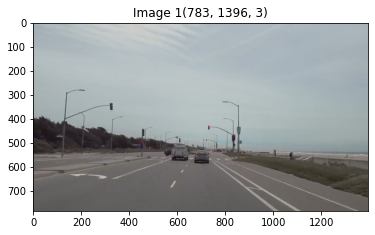

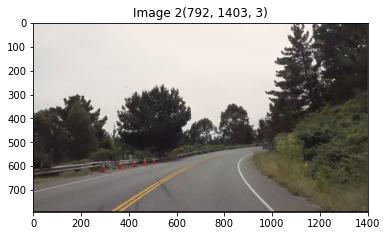

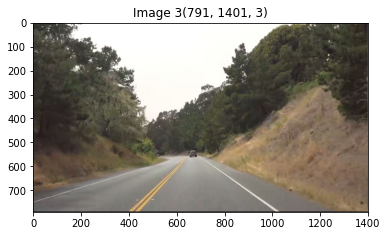

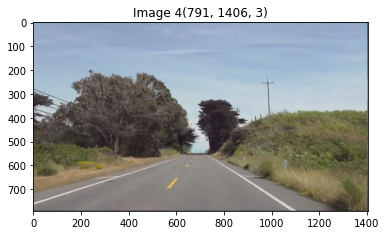

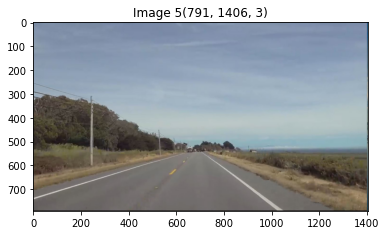

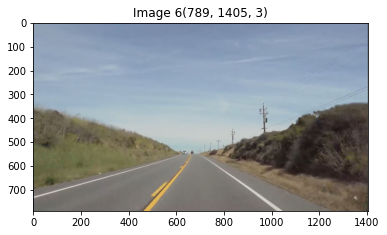

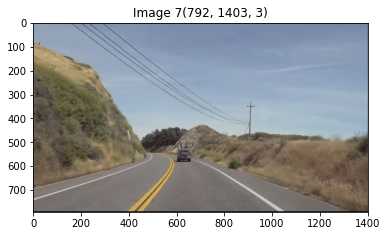

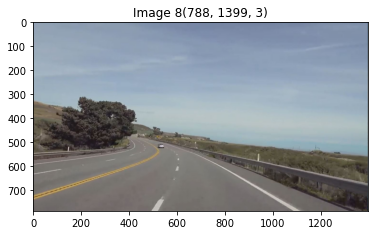

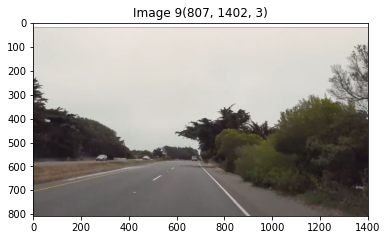

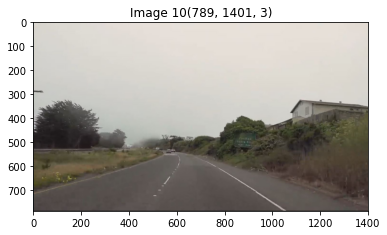

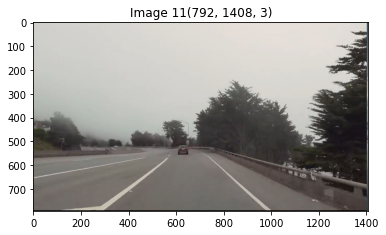

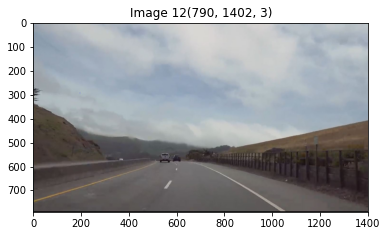

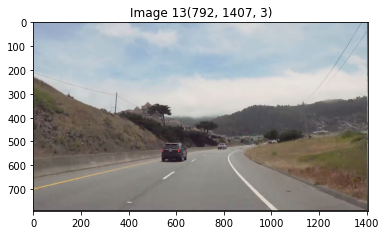

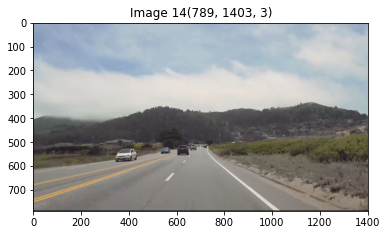

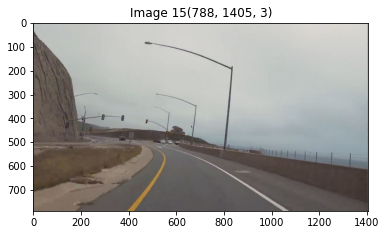

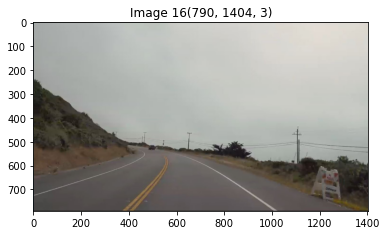

In [10]:
images_ar=[]
imgs_list=os.listdir('C:/Users/upadh/Pictures/imgs')
print(imgs_list)
for i in imgs_list:
    im=cv2.imread('C:/Users/upadh/Pictures/imgs/'+i)
    images_ar.append(im)
print(len(images_ar))
show_images(images_ar)
   

#### Getting the points for PerspectiveTransform
As here all of my images are of shape 790,1400,3 so therefore the my source and destination points are 
#### src=[(350,height),(600,600),(850,600),(1110,height)]
#### dst=[[200, height], [200, 0], [1000, 0], [1000, height]]
Note- for images with shapes not close to (790,1400,3) these values then the src and dst must be changed.

In [11]:
#for persepective transformation of the image
M_ar,Minv_ar=[],[]
for i in images_ar:
    height,width=i.shape[0],i.shape[1]
    pts = np.array([(350,height),(600,600),(850,600),(1110,height)], np.int32)
    src_pts = pts.astype(np.float32)
    dst_pts = np.array([[200, height], [200, 0], [1000, 0], [1000, height]], np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inv=cv2.getPerspectiveTransform(dst_pts,src_pts)
    M_ar.append(M)
    Minv_ar.append(M_inv)
    


#### Now applying PerspectiveTransform on images

In [12]:
warped_ar,warped_ar_size=[],[]
ind=0
for i in images_ar:
    img_size = (i.shape[1], i.shape[0])
    warped = cv2.warpPerspective(i, M_ar[ind], img_size, flags=cv2.INTER_LINEAR)
    warped_ar.append(warped)
    warped_size=(warped.shape[1], warped.shape[0])
    warped_ar_size.append(warped_size)
    ind=ind+1

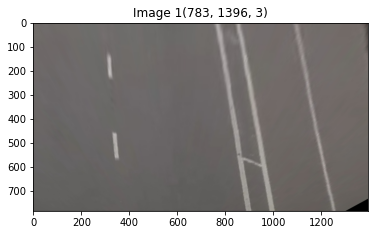

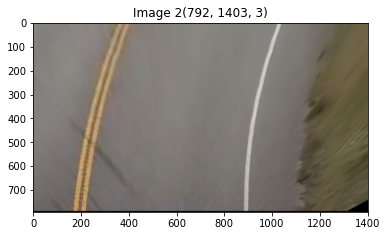

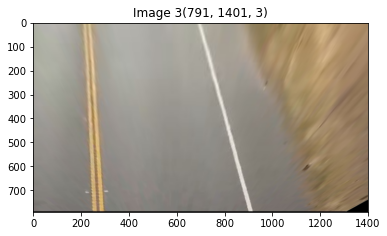

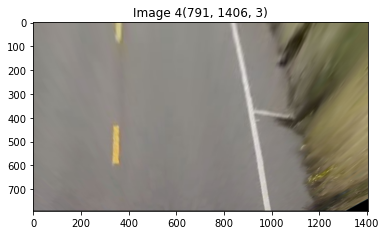

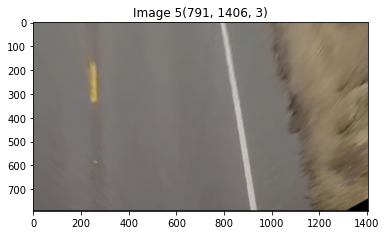

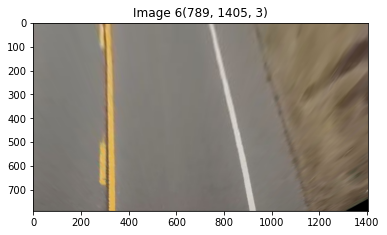

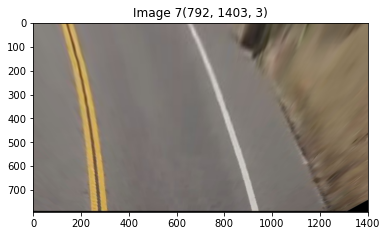

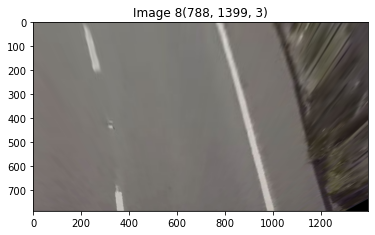

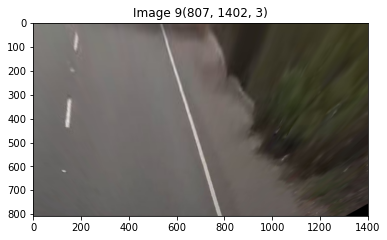

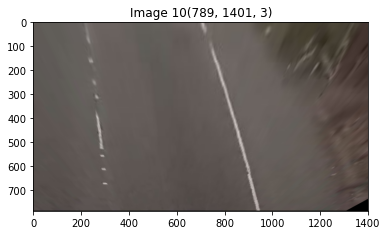

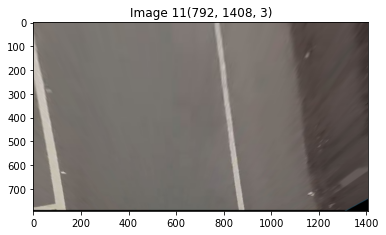

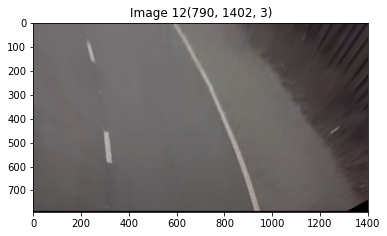

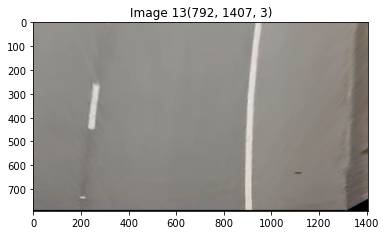

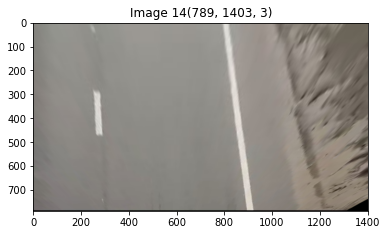

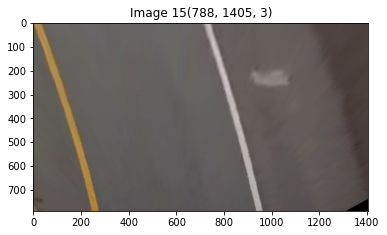

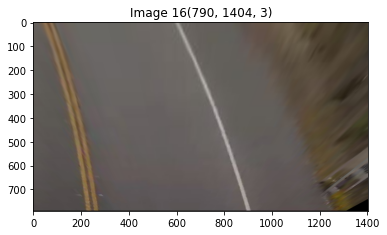

In [13]:
show_images(warped_ar)

#### As you can see the images above are transformed images or Bird's Eye View image now.
#### Now we will adjust the images intensities so that the average values of the image array fall in the range [90.0,105.0]. This is done to facilitate the image gradients filtering.
Note- If the lane is not detected properly in the sobely image then changing this range will help.

In [14]:
adjusted_warped=[]
def range_with_floats(start, stop, step):
    while stop > start:
        yield start
        start =start+ step
def range_with_floats_ng(start, stop, step):
    while stop < start:
        yield start
        start =start+ step
mx,mn=95.0,85.0
for warped in warped_ar:
    print("Before-",np.average(warped))
    if np.average(warped)>mx:
        for i in range_with_floats(1.0,50, 0.05):
            warped=np.array(255*(warped / 255) ** i, dtype = 'uint8')
            pp=np.average(warped)
            #print(pp)
            if pp>mn and pp<mx:
                break
            if pp<mn:
                break
    if np.average(warped)<mn:
        for i in range_with_floats_ng(1.0,0.0,-0.1):
            #print(i)
            warped=np.array(255*(warped / 255) ** i, dtype = 'uint8')
            pp=np.average(warped)
            #print(pp)
            if pp>mn and pp<mx:
                break
            if pp>mx:
                break
    print("After-",np.average(warped))
    adjusted_warped.append(warped)

Before- 105.99465480037229
After- 92.09108368982228
Before- 114.76260946360732
After- 87.80565724961662
Before- 142.1036518073148
After- 88.48460388747668
Before- 127.40157647167429
After- 92.53299297034742
Before- 115.72253223347774
After- 88.26898326898326
Before- 121.37439195822752
After- 94.27628377738387
Before- 117.77467565894152
After- 90.7476019400467
Before- 108.89558380472394
After- 90.59675118437269
Before- 88.48731881816323
After- 88.48731881816323
Before- 88.77405691571022
After- 88.77405691571022
Before- 107.85691042766682
After- 94.14658839818641
Before- 96.05090708270885
After- 91.16753492599481
Before- 135.79037382830916
After- 92.14733750679024
Before- 135.98961727555263
After- 92.61449046508764
Before- 93.75892359292111
After- 93.75892359292111
Before- 89.7785639583108
After- 89.7785639583108


#### Below is the warped image with adjusted image intensities

92.09108368982228


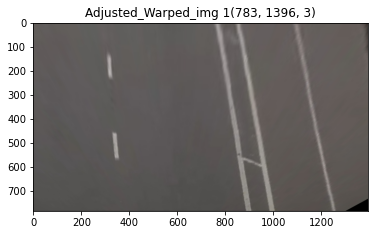

87.80565724961662


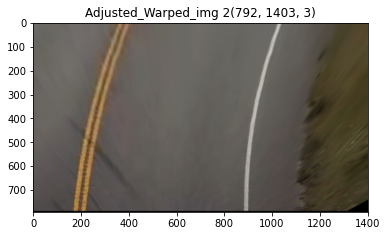

88.48460388747668


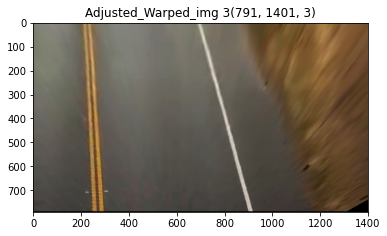

92.53299297034742


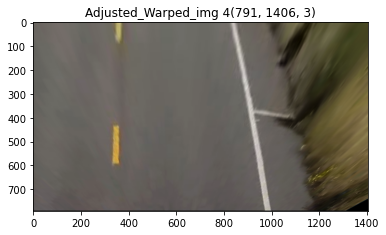

88.26898326898326


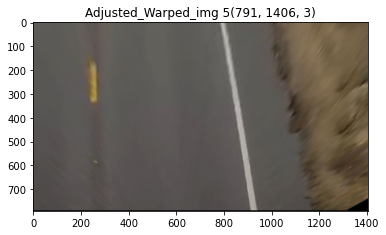

94.27628377738387


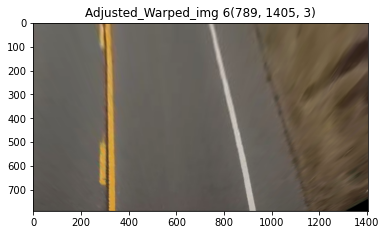

90.7476019400467


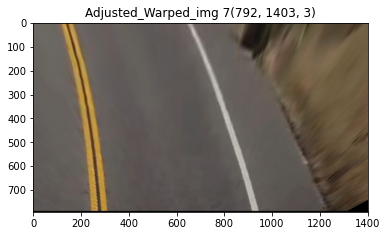

90.59675118437269


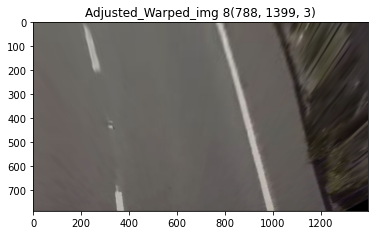

88.48731881816323


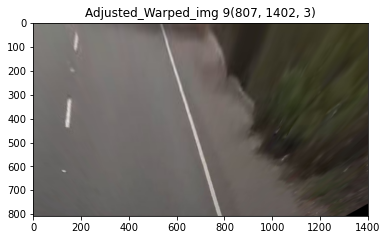

88.77405691571022


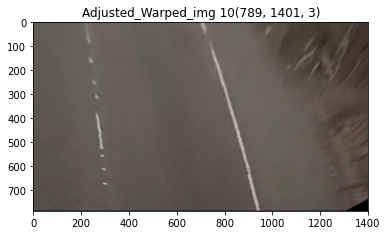

94.14658839818641


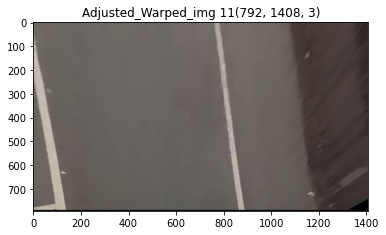

91.16753492599481


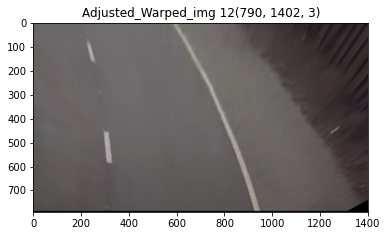

92.14733750679024


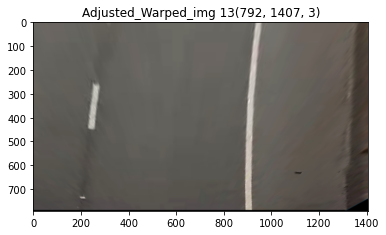

92.61449046508764


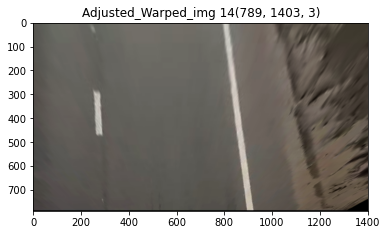

93.75892359292111


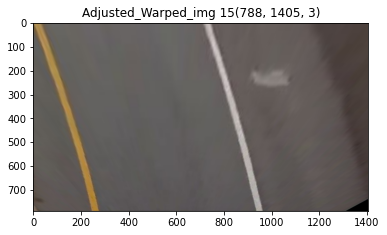

89.7785639583108


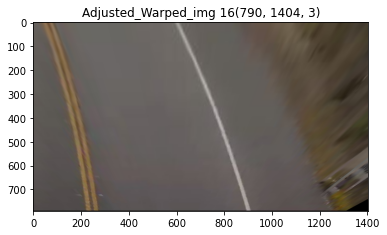

In [15]:
ind=1
for i in adjusted_warped:
    a="Adjusted_Warped_img "+str(ind)+str(i.shape)
    print(np.average(i))
    plt.title(a)
    plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))
    #plt.subplot(151)
    plt.show()
    ind=ind+1

#### Now we'll do image gradients filtering on adjusted_warped images

In [16]:
sobel_ar,sobel_ar1=[],[]
for warped in adjusted_warped:
    im_hls_pres=cv2.cvtColor(warped,cv2.COLOR_BGR2HLS)
    im_rgb_pres=cv2.cvtColor(warped,cv2.COLOR_BGR2RGB)
    gray_sep_pres=separate_white_and_yellow_bitwise_pres_gray(im_hls_pres,im_rgb_pres,warped)
    sobelx = cv2.Sobel(gray_sep_pres,cv2.CV_64F,0,4,ksize=5)
    sobely = cv2.Sobel(gray_sep_pres,cv2.CV_64F,4,4,ksize=5)
    sobelX = np.uint8(np.absolute(sobelx))
    sobelY = np.uint8(np.absolute(sobely))
    sobel_ar.append(sobely)
    sobel_ar1.append(sobelY)
    

In [17]:
#to display the sobel image 
"""while True:
    cv2.imshow("hg", sobel_ar[15])
    cv2.imshow("winname", adjusted_warped[15])
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        cv2.destroyAllWindows()
        break"""

'while True:\n    cv2.imshow("hg", sobel_ar[15])\n    cv2.imshow("winname", adjusted_warped[15])\n    if (cv2.waitKey(1) & 0xFF) == ord(\'q\'):\n        cv2.destroyAllWindows()\n        break'

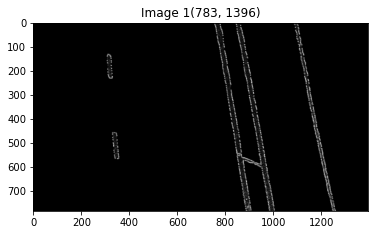

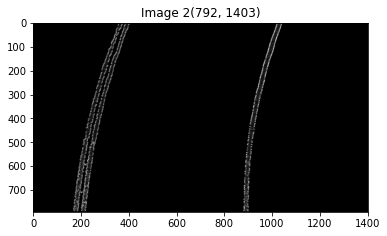

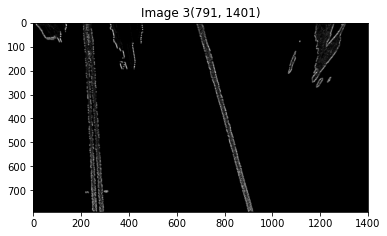

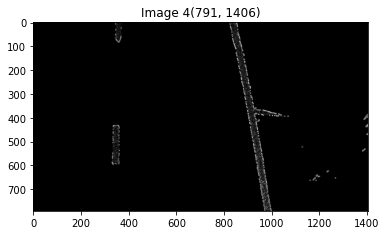

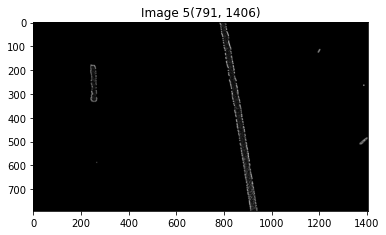

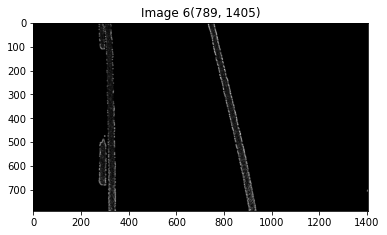

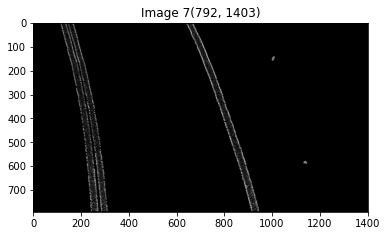

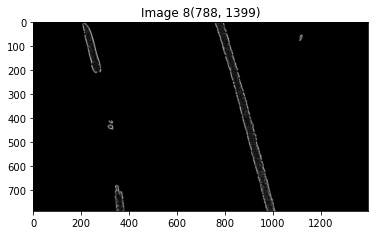

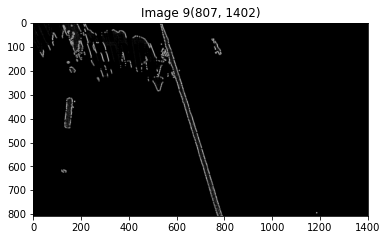

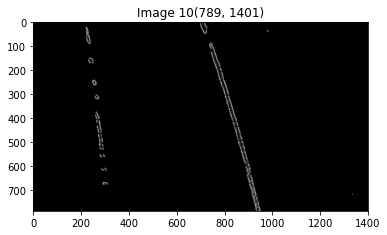

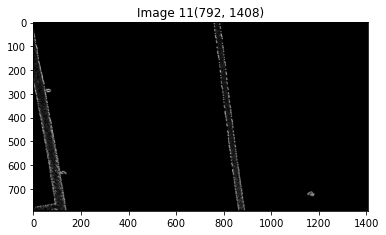

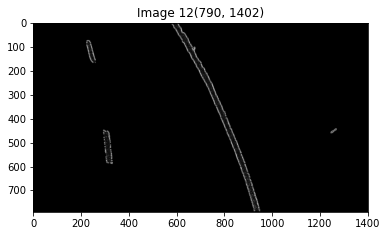

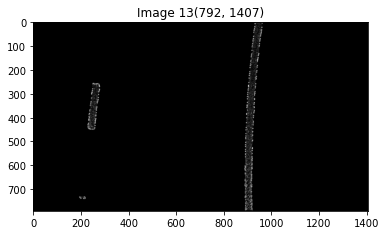

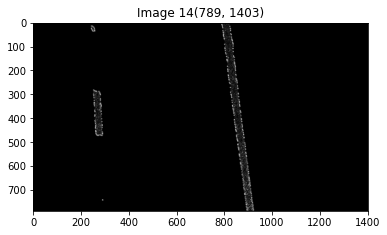

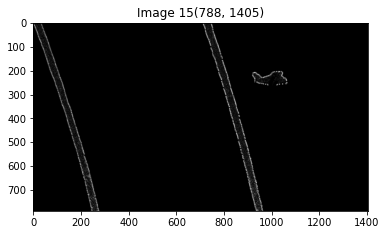

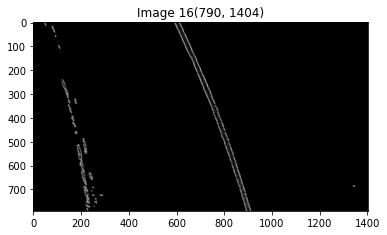

In [18]:
show_images(sobel_ar1)

#### Now we'll divide the above generated sobel images in left and right part. Here the sobel image is divided by the width such as the image from width 0-600 falls in left side and 600-width falls on the right side 

In [19]:
imml_ar,immr_ar=[],[]
for i in sobel_ar:
    width_to_break,max_width=600,200
    imml,immr=drbx(i,width_to_break,max_width)
    imml_ar.append(imml)
    immr_ar.append(immr)

imml_ar1,immr_ar1=[],[]
for i in sobel_ar1:
    width_to_break,max_width=600,200
    imml,immr=drbx(i,width_to_break,max_width)
    imml_ar1.append(imml)
    immr_ar1.append(immr)

#### Below are the divided images left and right

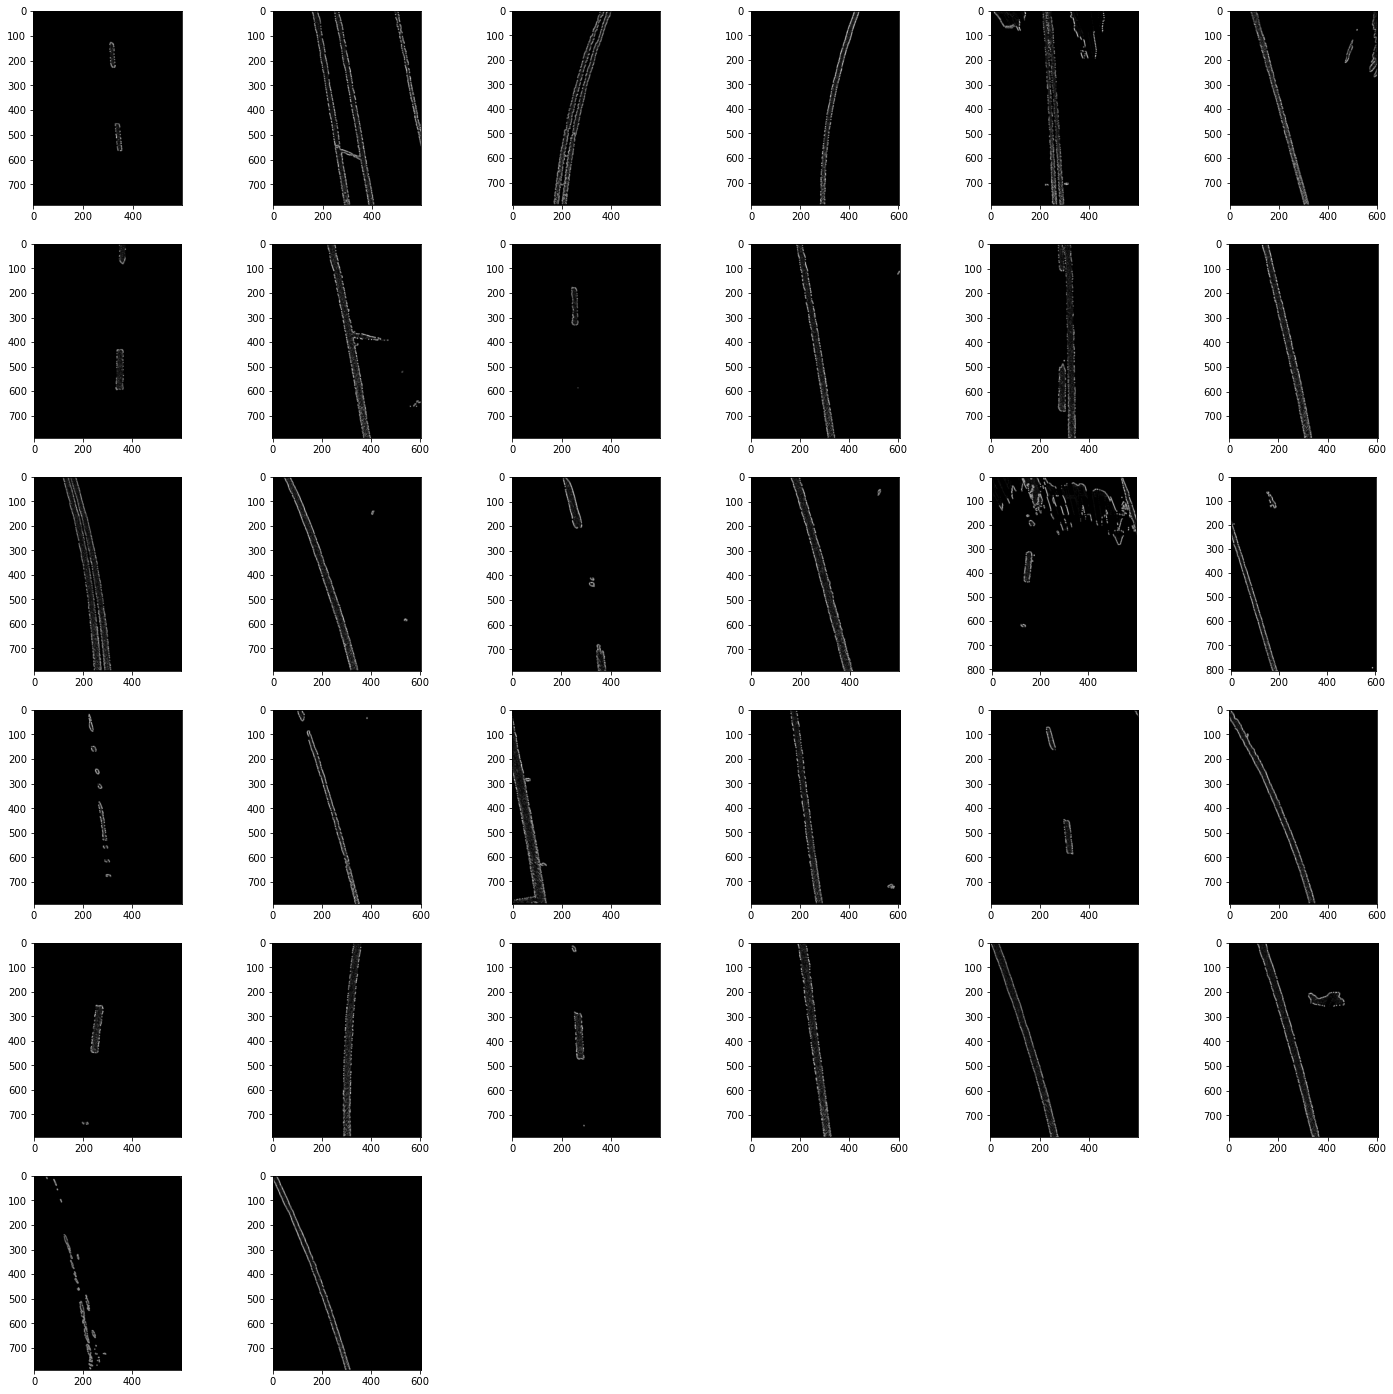

In [20]:
ar_dis=[]
for i in range(16):
    ar_dis.append(imml_ar1[i])
    ar_dis.append(immr_ar1[i])
plt.figure(figsize=(25,25)) # specifying the overall grid size

for i in range(32):
    plt.subplot(6,6,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(cv2.cvtColor(ar_dis[i],cv2.COLOR_BGR2RGB))

plt.show()

#### Getting the sliding windows on above images

In [21]:
boxesl,boxesr=[],[]
for i in range(0,len(imml_ar)):
    left=imml_ar[i]
    right=immr_ar[i]
    rightb114,boxesr1=get_slided_images_on_prespective199011_right(right,105,1,width_to_break)
    leftb114,boxesl1=get_slided_images_on_prespective199011_left(left,105,1)
    boxesl.append(boxesl1)
    boxesr.append(boxesr1)

#### After getting the coordinates of the sliding boxes draw_boxes() draws the boxes over the warped images, and thsese are warped images are again transformed back into the source points and using cv2.bitwise_or() we add these images witb the lanes detected on them to the orignal ones.

In [22]:
detected_boxes,lines=[],[]
ar1,ar2=[],[]
for i in range(0,16):
    warped_co=warped_ar[i].copy()
    res1,res2=draw_boxes1(warped_co,boxesl[i],boxesr[i],warped_co)
    warped_inv=cv2.warpPerspective(res1, Minv_ar[i], warped_ar_size[i], flags=cv2.INTER_LINEAR)
    warped_inv2=cv2.warpPerspective(res2, Minv_ar[i], warped_ar_size[i], flags=cv2.INTER_LINEAR)
    #print(images_ar[i].shape,warped_inv.shape)
    imcopy=images_ar[i]
    boxe=cv2.bitwise_or(images_ar[i],warped_inv)
    boxe2=cv2.bitwise_or(imcopy,warped_inv2)
    
    lines.append(boxe2)
    detected_boxes.append(boxe)
    

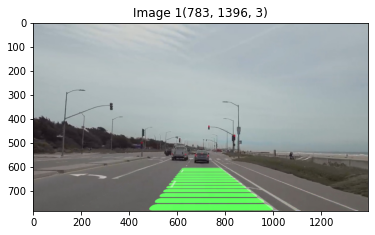

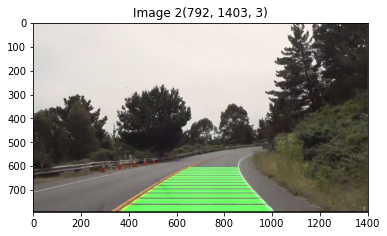

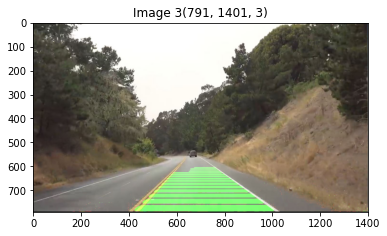

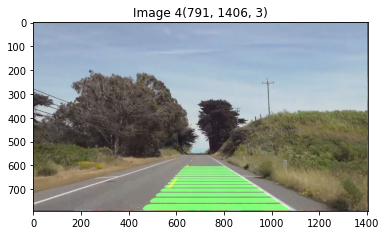

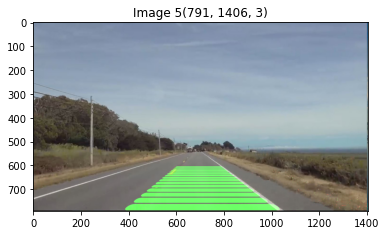

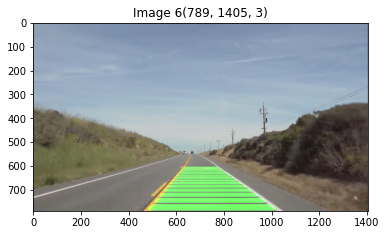

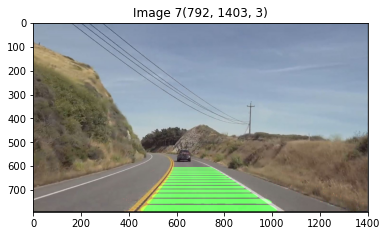

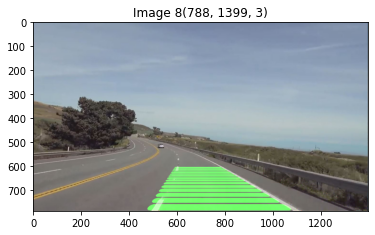

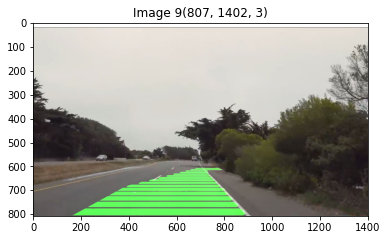

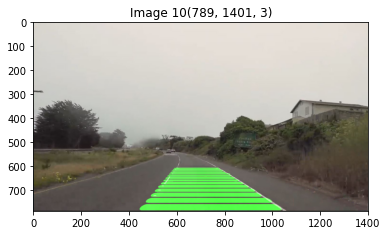

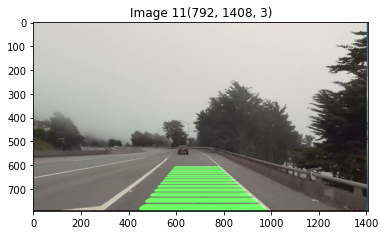

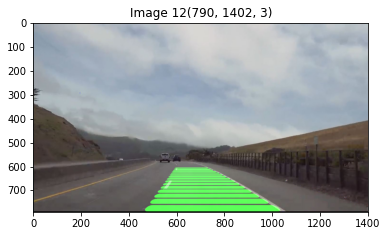

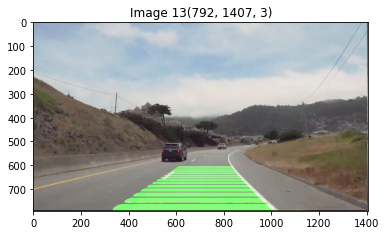

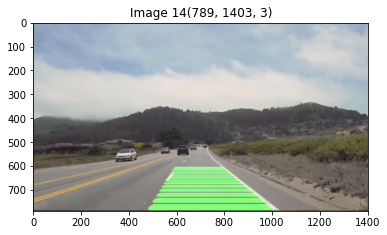

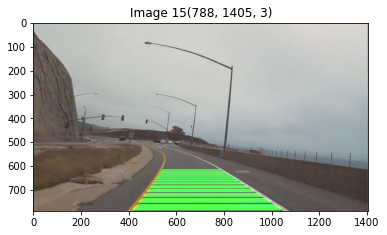

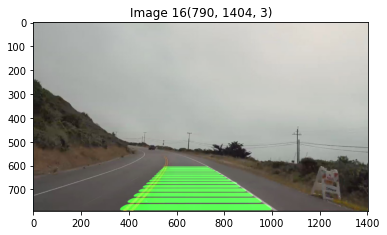

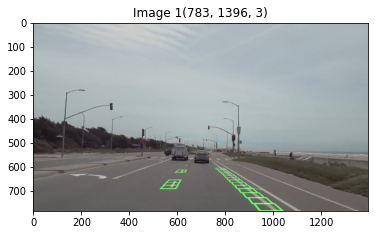

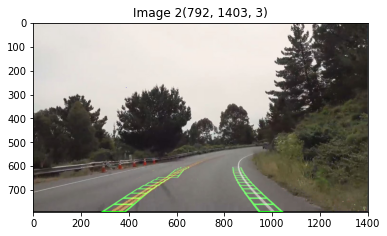

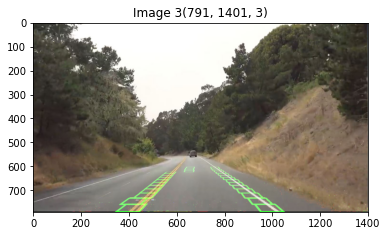

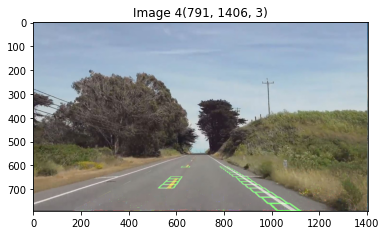

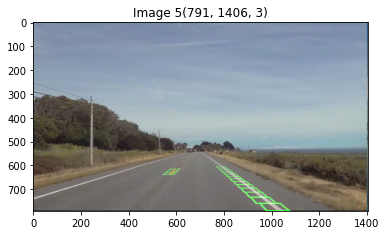

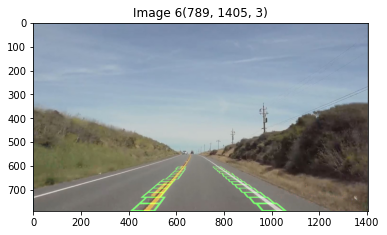

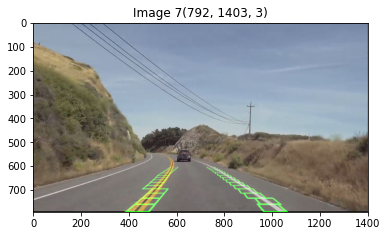

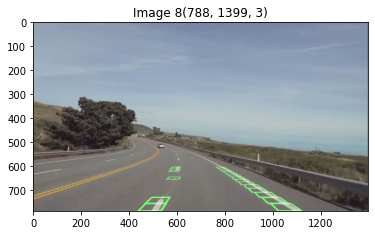

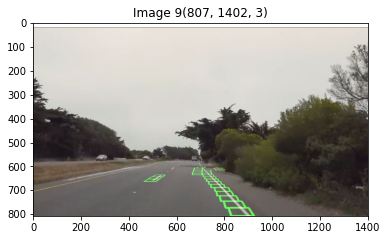

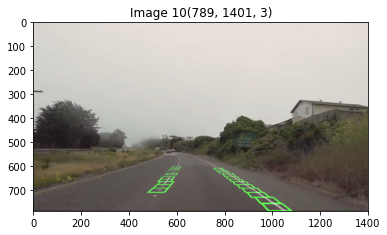

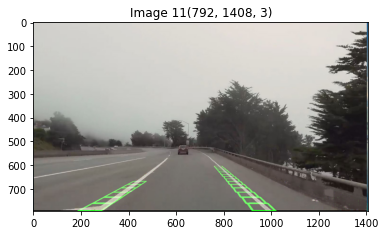

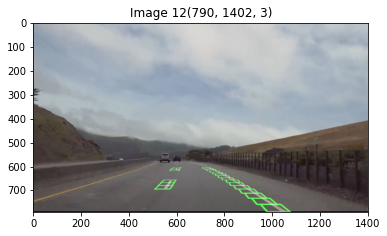

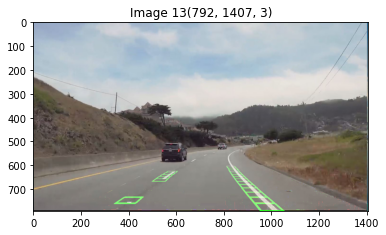

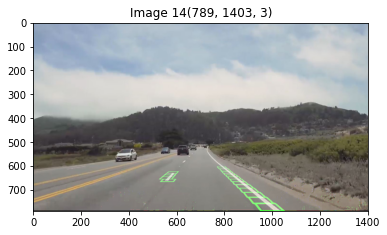

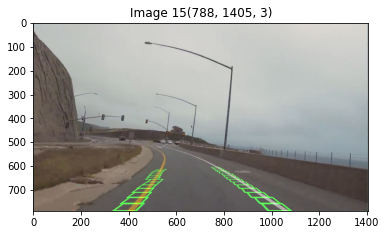

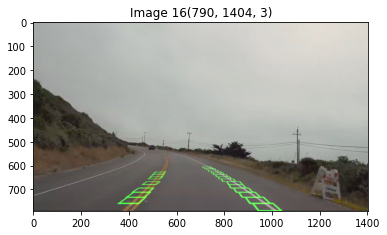

In [23]:
show_images(lines)
show_images(detected_boxes)

# On videos...

(720, 1280, 3)


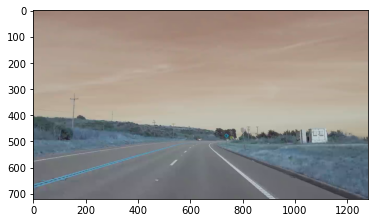

In [22]:
cap=cv2.VideoCapture('C:/Users/upadh/Videos/vid2.mp4')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
while True:
    _,img=cap.read()
    if not _:
        break
    image=np.array(img)
    print(image.shape)
    plt.imshow(image)
    break

In [41]:
cap=cv2.VideoCapture('C:/Users/upadh/Videos/vid1.mp4')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fp=int(cap.get(5))
print(fp)
out = cv2.VideoWriter('C:/Users/upadh/Videos/outpy1.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 25, (frame_width,frame_height))
def draw_r_o_i_canny_vid(image,coordinates):
    mask=np.zeros_like(image)
    #plt.imshow(mask)
    #no_of_ch=image.shape[2]
    mask_color=255
    #print(mask_color)
    cv2.fillPoly(mask,coordinates,mask_color)
    masked_img=cv2.bitwise_and(image,mask)
    #plt.imshow(masked_img)
    return masked_img

while True:
    
    _,img=cap.read()
    if not _:
        cv2.destroyAllWindows()
        break
    image=np.array(img)
    #image=np.array(255*(image / 255) ** 1.1, dtype = 'uint8')
    #print(np.average(image))
    height,width=image.shape[0],image.shape[1]
    #image = np.array(255*(image / 255) ** 2.2, dtype = 'uint8')
    image_c=image.copy()
    image_c1=image.copy()
    print(image.shape)
    image_c11=image.copy()
    #cv2.imshow("ori",image)
    #for persepective transformation of the image
    print(height,height-600)
    pts = np.array([(300,height),(490,570),(800,570),(1000,height)], np.int32)
    im=draw_r_o_i_canny_vid(image,np.array([pts],np.int32))
    mx,mn=80.0,90.0
    cv2.imshow("ori1",im)
    src_pts = pts.astype(np.float32)
    dst_pts = np.array([[100, height], [100, 0], [900, 0], [900, height]], np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inv=cv2.getPerspectiveTransform(dst_pts,src_pts)
    img_size = (image_c.shape[1], image_c.shape[0])
    warped = cv2.warpPerspective(image_c, M, img_size, flags=cv2.INTER_LINEAR)
    cv2.imshow("test",warped)
    warped_size=(warped.shape[1], warped.shape[0])
    #below is for adjusting the intensities images with the too high and too low average values
    warped_copy=warped.copy()
    #print(np.average(warped))
    #cv2.imshow("jj",warped[0:400,300:550])
    
    if np.average(warped)>mx:
        for i in range_with_floats(1.0,50, 0.05):
            warped=np.array(255*(warped / 255) ** i, dtype = 'uint8')
            pp=np.average(warped)
            #print(pp)
            if pp>mn and pp<mx:
                break
            if pp<mn:
                break
    if np.average(warped)<mn:
        for i in range_with_floats_ng(1.0,0.0,-0.05):
            warped=np.array(255*(warped / 255) ** i, dtype = 'uint8')
            pp=np.average(warped)
            if pp>mn and pp<mx:
                break
            if pp>mx:
                break
    #print(np.average(warped))
    im_hls_pres=cv2.cvtColor(warped,cv2.COLOR_BGR2HLS)
    im_rgb_pres=cv2.cvtColor(warped,cv2.COLOR_BGR2RGB)
    gray_sep_pres=separate_white_and_yellow_bitwise_pres_gray(im_hls_pres,im_rgb_pres,warped)
    sobelx = cv2.Sobel(gray_sep_pres,cv2.CV_64F,0,4,ksize=5)
    sobely = cv2.Sobel(gray_sep_pres,cv2.CV_64F,4,4,ksize=5)
    sobelX = np.uint8(np.absolute(sobelx))
    sobelY = np.uint8(np.absolute(sobely))
    sobelycp=sobely.copy()
    sobelycp12=sobely.copy()
    sobelycp1=sobely.copy()
    sobelycp111=sobely.copy()
    cv2.imshow("sd",sobely)
    width_to_break,max_width=550,150     #<----------------
    imml,immr=drbx(sobelycp12,width_to_break,max_width)
    cgh=immr.copy()
    cgh1=imml.copy()
    rightb114,boxesr1=get_slided_images_on_prespective199011_right(cgh,105,1,width_to_break)
    leftb114,boxesl1=get_slided_images_on_prespective199011_left(cgh1,105,1)
    cv2.imshow("rrr",rightb114)
    cv2.imshow("rppp",leftb114)
    res1,res2=draw_boxes1(warped_copy,boxesl1,boxesr1,warped_copy)
    cv2.imshow("result",res1)#box
    cv2.imshow("result1",res2)#lines
    warped_inv=cv2.warpPerspective(res1, M_inv, warped_size, flags=cv2.INTER_LINEAR)
    warped_inv2=cv2.warpPerspective(res2, M_inv, warped_size, flags=cv2.INTER_LINEAR)
    imagec1copy=image_c1.copy()
    #print(image_c1.shape,warped_inv.shape)
    boxe=cv2.bitwise_or(image_c1,warped_inv)
    boxe2=cv2.bitwise_or(imagec1copy,warped_inv2)
    cv2.imshow("dd1d",boxe)#box
    cv2.imshow("dd1d2",boxe2)#line
    out.write(boxe2)
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        cv2.destroyAllWindows()
        break
        
    


29
(720, 1280, 3)
720 120
(720, 1280, 3)
720 120
(720, 1280, 3)
720 120
(720, 1280, 3)
720 120
(720, 1280, 3)
720 120
(720, 1280, 3)
720 120
(720, 1280, 3)
720 120


## Below cell is use to grab the screen for detecting the lanes on images and videos.
If you are going to grab the screen then your bounding boxes will be different and therefore the coordinates for the PerspectiveTransform will vary.

In [37]:
sct = mss()
#these are the coordinates to grab the screen in a extended windows.
bounding_box = {'top': 230, 'left': 250, 'width': 1396, 'height': 783}
while True:
    
    #this for grabbing the screen
    #a video can be also use to read the images or frames and accordingly the coordinates will change
    sct_img = sct.grab(bounding_box)
    image=np.array(sct_img)
    height,width=image.shape[0],image.shape[1]
    #image = np.array(255*(image / 255) ** 2.2, dtype = 'uint8')
    image_c=image.copy()
    image_c1=image.copy()
    #print(image.shape)
    image_c11=image.copy()
    #print(height,height-600)
    #for persepective transformation of the image
    pts = np.array([(350,height),(600,600),(850,600),(1110,height)], np.int32)
    src_pts = pts.astype(np.float32)
    dst_pts = np.array([[200, height], [200, 0], [1000, 0], [1000, height]], np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inv=cv2.getPerspectiveTransform(dst_pts,src_pts)
    img_size = (image_c.shape[1], image_c.shape[0])
    warped = cv2.warpPerspective(image_c, M, img_size, flags=cv2.INTER_LINEAR)
    warped_size=(warped.shape[1], warped.shape[0])
    #below is for adjusting the intensities images with the too high and too low average values
    warped_copy=warped.copy()
    print(np.average(warped))
    cv2.imshow("jj",warped)
    if np.average(warped)>143.0:
        for i in range_with_floats(1.0,50, 0.05):
            warped=np.array(255*(warped / 255) ** i, dtype = 'uint8')
            pp=np.average(warped)
            #print(pp)
            if pp>130.0 and pp<143.0:
                break
            if pp<130.0:
                break
    if np.average(warped)<130.0:
        for i in range_with_floats_ng(1.0,0.0,-0.05):
            warped=np.array(255*(warped / 255) ** i, dtype = 'uint8')
            pp=np.average(warped)
            if pp>130.0 and pp<143.0:
                break
            if pp>143.0:
                break
    print(np.average(warped))
    im_hls_pres=cv2.cvtColor(warped,cv2.COLOR_BGR2HLS)
    im_rgb_pres=cv2.cvtColor(warped,cv2.COLOR_BGR2RGB)
    gray_sep_pres=separate_white_and_yellow_bitwise_pres_gray(im_hls_pres,im_rgb_pres,warped)
    sobelx = cv2.Sobel(gray_sep_pres,cv2.CV_64F,0,4,ksize=5)
    sobely = cv2.Sobel(gray_sep_pres,cv2.CV_64F,4,4,ksize=5)
    sobelX = np.uint8(np.absolute(sobelx))
    sobelY = np.uint8(np.absolute(sobely))
    sobelycp=sobely.copy()
    sobelycp12=sobely.copy()
    sobelycp1=sobely.copy()
    sobelycp111=sobely.copy()
    
    cv2.imshow("sobvekl",sobely)
    
    width_to_break,max_width=600,200
    imml,immr=drbx(sobelycp12,width_to_break,max_width)
    cv2.imshow("a",imml)
    cv2.imshow("b",immr)
    cgh=immr.copy()
    cgh1=imml.copy()
    rightb114,boxesr1=get_slided_images_on_prespective199011_right(cgh,105,1,width_to_break)
    leftb114,boxesl1=get_slided_images_on_prespective199011_left(cgh1,105,1)
    res1,res2=draw_boxes1(warped_copy,boxesl1,boxesr1,warped_copy)
    cv2.imshow("result",res1)#box
    cv2.imshow("result1",res2)#lines
    warped_inv=cv2.warpPerspective(res1, M_inv, warped_size, flags=cv2.INTER_LINEAR)
    warped_inv2=cv2.warpPerspective(res2, M_inv, warped_size, flags=cv2.INTER_LINEAR)
    imagec1copy=image_c1.copy()
    #print(image_c1.shape,warped_inv.shape)
    boxe=cv2.bitwise_or(image_c1,warped_inv)
    boxe2=cv2.bitwise_or(imagec1copy,warped_inv2)
    cv2.imshow("dd1d",boxe)#box
    cv2.imshow("dd1d2",boxe2)#line
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        cv2.destroyAllWindows()
        break

87.8312362542861
138.80934283137006
87.8312362542861
138.80934283137006
